In [ ]:
pip install spotipy

In [2]:
pip install mysql-connector-python

     |████████████████████████████████| 25.4MB 112kB/s 


# Database

Let's create and connect to a database

In [15]:
import sqlite3

database = sqlite3.connect('spotify.db')

Let's create a table for our streaming history

In [19]:
#create
database.execute("""CREATE TABLE IF NOT EXISTS streaming_history(
                    endTime DATETIME,
                    artistName varchar(40),
                    trackName varchar(40),
                    msPlayed int,
                    id INTEGER PRIMARY KEY AUTOINCREMENT);""")
database.commit()

Now let's insert our streaming history JSON into the database.

In [28]:
import json

with open("/content/StreamingHistory0.json", 'r') as file:
  data = json.loads(file.read())

print(data[:4])

[{'endTime': '2020-06-24 07:45', 'artistName': 'Foo Fighters', 'trackName': 'These Days', 'msPlayed': 294417}, {'endTime': '2020-06-25 00:02', 'artistName': 'NF', 'trackName': 'One Hundred', 'msPlayed': 192800}, {'endTime': '2020-06-25 00:06', 'artistName': 'NF', 'trackName': 'Outro', 'msPlayed': 212186}, {'endTime': '2020-06-25 00:09', 'artistName': 'NF', 'trackName': 'Intro 2', 'msPlayed': 195933}]


In [33]:
keys = ["endTime", "artistName", "trackName", "msPlayed"]

for item in data:
    values = [item.get(key, None) for key in keys]
    cmd = """INSERT INTO streaming_history VALUES(?, ?, ?, ?, null);"""
    database.execute(cmd, values)

database.commit()

Check if it worked

In [36]:
cmd = """SELECT * FROM streaming_history LIMIT 5;"""
cur = database.execute(cmd)
res = cur.fetchall()
for r in res:
  print(r)

('2020-06-24 07:45', 'Foo Fighters', 'These Days', 294417, 1)
('2020-06-25 00:02', 'NF', 'One Hundred', 192800, 2)
('2020-06-25 00:06', 'NF', 'Outro', 212186, 3)
('2020-06-25 00:09', 'NF', 'Intro 2', 195933, 4)
('2020-06-25 00:14', 'NF', 'Therapy Session', 331480, 5)


The target is now to create another table which contains the artist and the genre.

In [40]:
cmd = """SELECT DISTINCT artistName FROM streaming_history;"""
cur = database.execute(cmd)
artist_list = cur.fetchall()

print("We have " + str(len(artist_list)) + " different artists")

We have 1088 different artists


Let's get our spotify information

In [44]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

id = '627414d9842a40a9941c69152d1ef5d4'
secret = '9b1249549b214a9e9bd26f45cda8f44a'

auth_manager = SpotifyClientCredentials(client_id=id, client_secret=secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [49]:
values = []

for item in artist_list:
  artistName = item[0]
  results = sp.search(q=artistName, type='artist')
  
  try:
    results = results["artists"]["items"][0]
    genres = results["genres"]

    for genre in genres:
      value = (artistName, genre)
      values.append(value)
    
  except:
    print("not found: " + artistName)


not found: Asaf Avidan & the Mojos
not found: Benny Benassi presents The Biz
not found: The Explicits
not found: Science Weekly


In [50]:
#create
database.execute("""CREATE TABLE IF NOT EXISTS artist_genres(
                    artistName varchar(40),
                    genreName varchar(40),
                    id INTEGER PRIMARY KEY AUTOINCREMENT);""")
database.commit()

In [51]:
for value in values:
    cmd = """INSERT INTO artist_genres VALUES(?, ?, null);"""
    database.execute(cmd, value)

database.commit()

In [52]:
cmd = """SELECT * FROM artist_genres LIMIT 5;"""
cur = database.execute(cmd)
res = cur.fetchall()
for r in res:
  print(r)

('Foo Fighters', 'alternative metal', 1)
('Foo Fighters', 'alternative rock', 2)
('Foo Fighters', 'modern rock', 3)
('Foo Fighters', 'permanent wave', 4)
('Foo Fighters', 'post-grunge', 5)


Let's try to get every modern rock from streaming history

In [55]:
cmd = """ SELECT streaming_history.endTime, streaming_history.artistName, streaming_history.trackName, artist_genres.genreName
          FROM streaming_history
          INNER JOIN artist_genres ON streaming_history.artistName=artist_genres.artistName 
          WHERE artist_genres.genreName='modern rock'; """

cur = database.execute(cmd)
modern_rock_streaming_history = cur.fetchall()

In [56]:
print(modern_rock_streaming_history[:3])

[('2020-06-24 07:45', 'Foo Fighters', 'These Days', 'modern rock'), ('2020-06-28 15:20', 'Foo Fighters', 'Concrete and Gold', 'modern rock'), ('2020-07-01 13:25', 'Foo Fighters', 'These Days', 'modern rock')]


Now let's look at the streaming time.

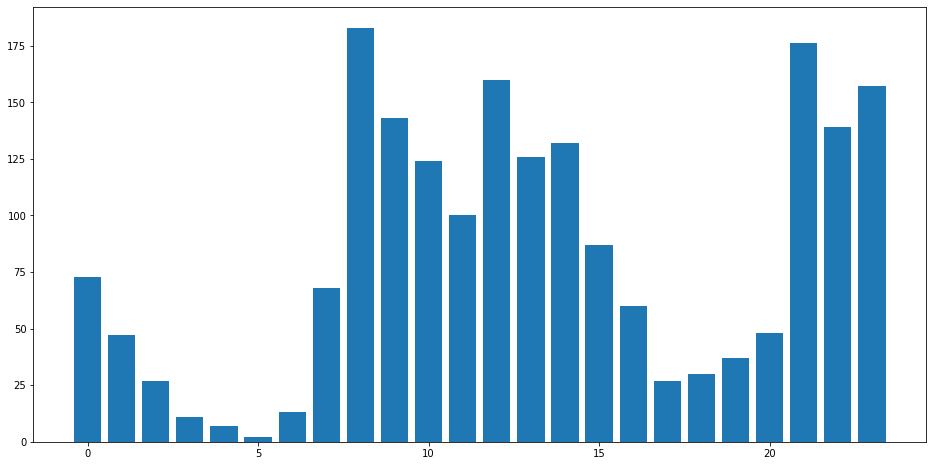

In [63]:
from datetime import datetime
import matplotlib.pyplot as plt

def plotHourlyStreamingHistory(time):
  hours = [0 for y in range(24)]
  y = [y for y in range(24)]
  
  for t in time:
    date = datetime.strptime(t[0], '%Y-%m-%d %H:%M')
    hours[date.hour] += 1
  
  fig, ax = plt.subplots(figsize=(16, 8))
  ax.bar(y, hours)
  plt.show()

plotHourlyStreamingHistory(modern_rock_streaming_history)

Let's compare that to heavy metal

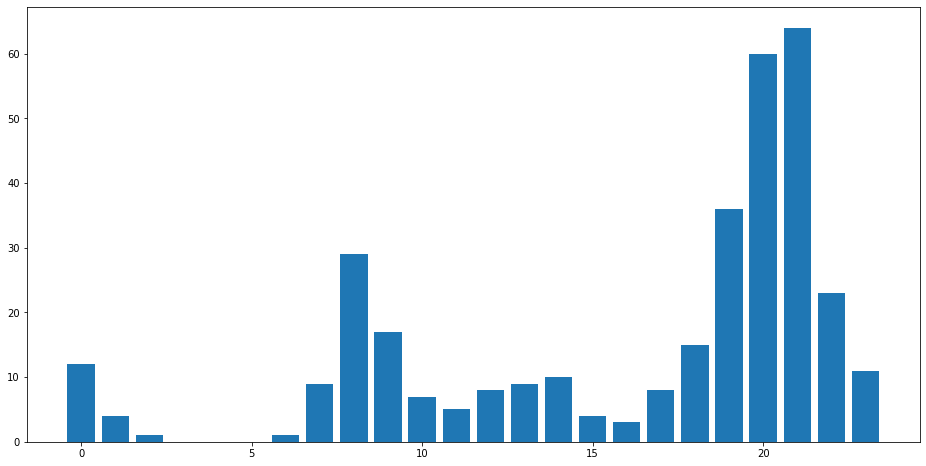

In [67]:
cmd = """ SELECT streaming_history.endTime, streaming_history.artistName, streaming_history.trackName, artist_genres.genreName
          FROM streaming_history
          INNER JOIN artist_genres ON streaming_history.artistName=artist_genres.artistName 
          WHERE artist_genres.genreName='metal'; """

cur = database.execute(cmd)
heavy_metal_streaming_history = cur.fetchall()
plotHourlyStreamingHistory(heavy_metal_streaming_history)

To be able to better compare what's going on, let's look at which are the most popular genres and then plot them against each other.

In [81]:
cmd = """ SELECT genreName, COUNT(*) FROM
          (
          SELECT artist_genres.genreName, streaming_history.trackName
          FROM streaming_history
          INNER JOIN artist_genres ON streaming_history.artistName=artist_genres.artistName
          )
          GROUP BY genreName
          ORDER BY COUNT(*) DESC;
          """

cur = database.execute(cmd)
res = cur.fetchall()
print("So my most popular streamed genres:")
for i in range(10):
  print(res[i])

So my most popular streamed genres:
('rock', 3213)
('modern rock', 1977)
('pop', 1643)
('classic rock', 1277)
('album rock', 1100)
('permanent wave', 851)
('mellow gold', 828)
('art rock', 751)
('soft rock', 743)
('hard rock', 736)


In [ ]:
#close
database.close()

# Playlist Analysis

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

id = '627414d9842a40a9941c69152d1ef5d4'
secret = '9b1249549b214a9e9bd26f45cda8f44a'

auth_manager = SpotifyClientCredentials(client_id=id, client_secret=secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [ ]:
def get_playlist_tracks(username, playlist_id):
  results = sp.user_playlist_tracks(username, playlist_id)
  tracks = results['items']
  while results['next']:
    results = sp.next(results)
    tracks.extend(results['items'])
  return tracks

tracks = get_playlist_tracks("timo1701", "09PpyE5sNUzEduVcpFyjwH")

In [ ]:
def get_tracks_features(tracks):
  features = []

  for i, t in enumerate(tracks):
    id = t["track"]["id"]
    feature = sp.audio_features(id)
    features.extend(feature)

    if i%100  == 0:
      print(i)

  return features

features = get_tracks_features(tracks)

Let's save those information.

In [ ]:
import json

def save_features(name, features):
  with open(name + ".json", 'w', encoding='utf-8') as file:
    json.dump(features, file)

def load_features(name):
  with open(name + ".json", "r") as file:
    features = json.load(file)
  return features

In [ ]:
import matplotlib.pyplot as plt

def feature_hist(ax, name, features, bins):
  feature = [item[name] for item in features]
  ax.hist(feature, bins=bins)
  ax.title.set_text(name)

fig, axs = plt.subplots(4, 2, figsize=(16, 16))

'''
feature_hist(axs[0, 0], "danceability", features, 30, (0.0, 1.0))
feature_hist(axs[0, 1], "energy", features, 30, (0.0, 1.0))

feature_hist(axs[1, 0], "loudness", features, 30, (0.0, 1.0))
feature_hist(axs[1, 1], "speechiness", features, 30, (0.0, 1.0))

feature_hist(axs[2, 0], "acousticness", features, 30)
feature_hist(axs[2, 1], "instrumentalness", features, 30)

feature_hist(axs[3, 0], "liveness", features, 30)
feature_hist(axs[3, 1], "valence", features, 30)
'''

So what does that learn us? Not much really, we need to compare to others playlists. Let's take those made by spotify.

In [ ]:
#classical enssentials
classic_tracks = get_playlist_tracks("timo1701", "37i9dQZF1DWWEJlAGA9gs0")
classic_features = get_tracks_features(classic_tracks)

0
100


In [ ]:
#rock classics
rock_tracks = get_playlist_tracks("timo1701", "37i9dQZF1DWXRqgorJj26U")
rock_features = get_tracks_features(rock_tracks)

0
100


In [ ]:
#heavy metal
metal_tracks = get_playlist_tracks("timo1701", "37i9dQZF1DX9qNs32fujYe")
metal_features = get_tracks_features(metal_tracks)

0
100


In [ ]:
#jazz classics
jazz_tracks = get_playlist_tracks("timo1701", "37i9dQZF1DXbITWG1ZJKYt")
jazz_features = get_tracks_features(jazz_tracks)

0
100


TypeError: ignored

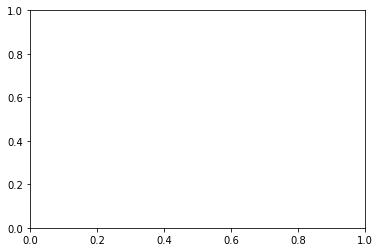

In [ ]:
fig, ax = plt.subplot()

feature_hist(ax, "danceability", classic_features, 10)
feature_hist(ax, "danceability", rock_features, 10)
feature_hist(ax, "danceability", metal_features, 10)
feature_hist(ax, "danceability", jazz_features, 10)

# Data Analysis

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

def getData(path, n):
  data = []
  for i in range(n):
    name = path + "StreamingHistory" + str(i) + ".json"
    with open(name) as f:
      data += json.load(f)
  return data

def getTime(data):
  time = []
  for item in data:
      t = item['endTime']
      t = datetime.strptime(t, '%Y-%m-%d %H:%M')
      time.append(t)
  return time

data = getData("/content/", 5)
time = getTime(data)

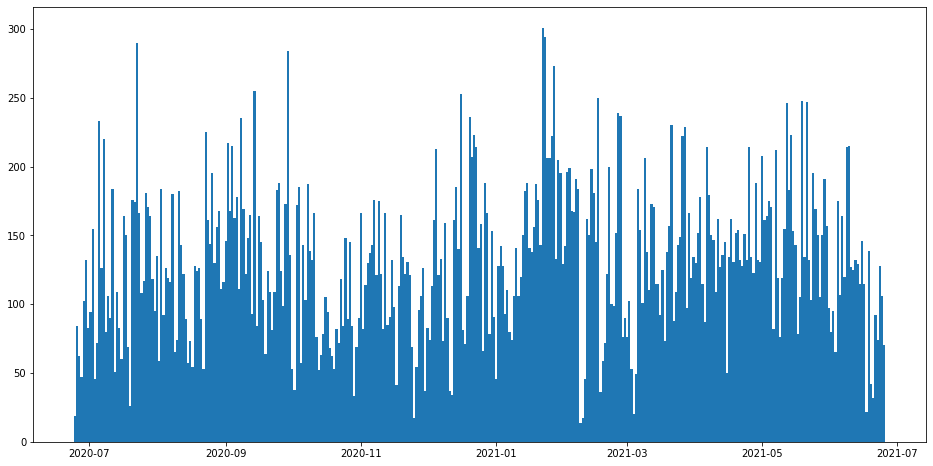

In [ ]:
def plotDailyStreamingHistory(time):
  start = time[0]
  end = time[-1]
  delta = (end - start).days

  # plot it
  fig, ax = plt.subplots(figsize=(16, 8))
  ax.hist(time, bins=delta)
  locator = mdates.AutoDateLocator()
  ax.xaxis.set_major_locator(locator)
  ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
  plt.show()

plotDailyStreamingHistory(time)

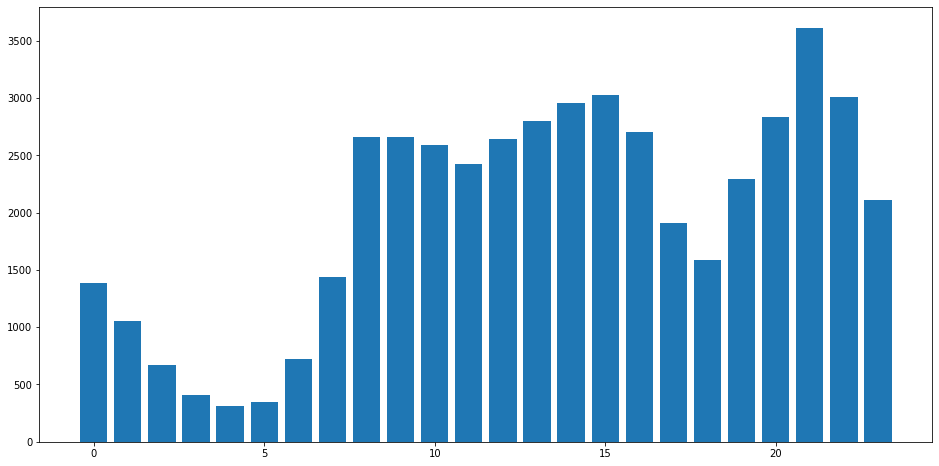

In [ ]:
def plotHourlyStreamingHistory(time):
  hours = [0 for y in range(24)]
  y = [y for y in range(24)]
  
  for t in time:
    hours[t.hour] += 1
  
  fig, ax = plt.subplots(figsize=(16, 8))
  ax.bar(y, hours)
  plt.show()

plotHourlyStreamingHistory(time)

Let's look at my most popular songs and many times I've played them.

In [ ]:
# count = {'count':, 'artistName': , 'trackName': , 'msPlayed':}

def countSongOccurrences(time):
  occurences = []

  while len(time) > 0:
    artistName = time[-1]["artistName"]
    trackName = time[-1]["trackName"]
    msPlayed = 0
    count = 0
    
    for i in reversed(range(len(time))):
      if time[i]["trackName"] == trackName:
        count += 1
        msPlayed += time[i]["msPlayed"]
        time.pop(i)

    minPlayed = int(msPlayed / (1000 * 60))
    occurence = {'count': count, 'artistName': artistName, 'trackName': trackName, "minPlayed": minPlayed}
    occurences.append(occurence)

  return occurences

data = getData("/content/", 5)
song_occurences = countSongOccurrences(data)

In [ ]:
# count = {'count':, 'artistName': , 'msPlayed':}

def countArtistOccurrences(data):
  occurences = []

  while len(data) > 0:
    artistName = data[-1]["artistName"]
    count = 0
    msPlayed = 0
    
    for i in reversed(range(len(data))):
      if data[i]["artistName"] == artistName:
        count += 1
        msPlayed += data[i]["msPlayed"]
        data.pop(i)

    minPlayed = int(msPlayed / (1000 * 60))
    occurence = {'count': count, 'artistName': artistName, "minPlayed": minPlayed}
    occurences.append(occurence)

  return occurences

data = getData("/content/", 5)
artist_occurences = countArtistOccurrences(data)

In [ ]:
favorite_song = sorted(song_occurences, key=lambda x: x['count'], reverse=True) 
print("Favorite Songs")
for i in range(10):
  print(favorite_song[i])

Favorite Songs
{'count': 117, 'artistName': 'Imagine Dragons', 'trackName': 'Birds', 'minPlayed': 409}
{'count': 112, 'artistName': 'The xx', 'trackName': 'Intro', 'minPlayed': 174}
{'count': 100, 'artistName': 'The Districts', 'trackName': '4th and Roebling', 'minPlayed': 365}
{'count': 90, 'artistName': 'The Districts', 'trackName': '6 AM', 'minPlayed': 426}
{'count': 86, 'artistName': 'Machine Gun Kelly', 'trackName': 'forget me too (feat. Halsey)', 'minPlayed': 210}
{'count': 81, 'artistName': 'Videoclub', 'trackName': 'Enfance 80', 'minPlayed': 247}
{'count': 81, 'artistName': 'Machine Gun Kelly', 'trackName': "I Think I'm OKAY (with YUNGBLUD & Travis Barker)", 'minPlayed': 205}
{'count': 79, 'artistName': 'grandson', 'trackName': 'Identity', 'minPlayed': 220}
{'count': 75, 'artistName': 'Alan Walker', 'trackName': 'Darkside', 'minPlayed': 234}
{'count': 75, 'artistName': 'grandson', 'trackName': 'Blood // Water', 'minPlayed': 170}


In [ ]:
favorite_artist = sorted(artist_occurences, key=lambda x: x['count'], reverse=True) 
print("Favorite Artist")
for i in range(10):
  print(favorite_artist[i])

Favorite Artist
{'count': 1540, 'artistName': 'The Districts', 'minPlayed': 5780}
{'count': 1436, 'artistName': 'Machine Gun Kelly', 'minPlayed': 3192}
{'count': 867, 'artistName': 'grandson', 'minPlayed': 2400}
{'count': 776, 'artistName': 'Alan Walker', 'minPlayed': 2064}
{'count': 767, 'artistName': 'Supertramp', 'minPlayed': 3333}
{'count': 761, 'artistName': 'Robin Schulz', 'minPlayed': 2348}
{'count': 755, 'artistName': 'EDEN', 'minPlayed': 2684}
{'count': 724, 'artistName': 'Oh Wonder', 'minPlayed': 2310}
{'count': 637, 'artistName': 'French 79', 'minPlayed': 2370}
{'count': 612, 'artistName': 'NF', 'minPlayed': 2012}


In [ ]:
data = getData("/content/", 5)

print("Number of streams: " + str(len(data)))
print("Number of different songs: " + str(len(favorite_song)))
print("Number of different artists: " + str(len(favorite_artist)))

Number of streams: 48147
Number of different songs: 10484
Number of different artists: 3627


Now split our song history in different genres. We will for each artist in "favorite artist" find the genre(s) with the spotipy api and then parse over the streaming history to classify the stream into the different genres.

In [ ]:
for i in range(len(favorite_artist)):
  #find artist
  artist = favorite_artist[i]
  name = artist["artistName"]
  results = sp.search(q=name, type='artist')
  
  try:  
    results = results["artists"]["items"][0]

    #extract information
    genres = results["genres"]
    popularity = results["popularity"]
  
    #add informations
    artist["genres"] = genres
    artist["popularity"] = popularity
  except:
    print("not found: " + name)

not found: The Yes Theory Podcast
not found: Benny Benassi presents The Biz
not found: rSlash
not found: Radio Headspace
not found: Science Weekly
not found: The Explicits
not found: Asaf Avidan & the Mojos


So now we will loop through the streaming history and add each stream to the corresponding genre.

In [ ]:
#to avoid any problems we add a boiler plate artist
artist = {'count': 0, 'artistName': '', 'minPlayed': 0, 'genres': [], 'popularity': 0}
favorite_artist.append(artist)

In [ ]:
def getArtistIndex(favorite_artist, artistName):
  for i in range(len(favorite_artist)):
    if favorite_artist[i]["artistName"] == artistName:
      #return index
      return i

  #return our boilerplate artist
  return -1

genres = []

for song in data:
  #we get the artist index
  index = getArtistIndex(favorite_artist, song["artistName"])
  
  try:
    #we get the artist genres
    artist_genres = favorite_artist[index]["genres"]

    #we add to each song the artist genres
    song["genres"] = artist_genres
    
    #we add the genre to the list of genres
    genres.extend(artist_genres)
  except:
    pass

In [ ]:
genres = sorted(genres)
listed_genres = [] #let's filter the genres

while len(genres) > 0:
  c = 0
  name = genres[0]

  #remove from list
  while len(genres) > 0 and genres[0] == name:
    genres.pop(0)
    c += 1
  
  genre = {"name": name, "count": c}
  listed_genres.append(genre)

In [ ]:
listed_genres = sorted(listed_genres, key=lambda x: x['count'], reverse=True)
print("favorite genres")
for i in range(10):
  print(listed_genres[i])

favorite genres
{'name': 'rock', 'count': 10588}
{'name': 'modern rock', 'count': 8954}
{'name': 'pop', 'count': 8917}
{'name': 'electropop', 'count': 4502}
{'name': 'classic rock', 'count': 3929}
{'name': 'indie poptimism', 'count': 3666}
{'name': 'tropical house', 'count': 3507}
{'name': 'dance pop', 'count': 3418}
{'name': 'pop rock', 'count': 3265}
{'name': 'french indie pop', 'count': 3096}


Now subdivide our list to each genre

In [ ]:
#initialize 
for genre in listed_genres:
  genre["streamingHistory"] = []

In [ ]:
for song in data:
  for genre in song["genres"]:
    listed_genre = [listed_genre for listed_genre in listed_genres if listed_genre == genre]
    print(listed_genre)
  break

[]
[]
[]
[]
[]
[]
